## Оглавление
* [1. Загрузка данных](#load)
* [2. EDA](#eda)
    * [2.1 Распределение целевой переменной](#target)
    * [2.2 Анализ признаков](#features)
        * [2.2.1 Количественные признаки](#num_features)
        * [2.2.2 Категориальные признаки](#cat_features)
        * [2.2.3 Бинарные признаки](#binary_features)
        * [2.2.4 Матрица корреляций](#corr)
* [3. Проверка данных](#data_check)
    * [3.1 Обработка выбросов](#outlier)
    * [3.2 Обработка пропусков](#nan)
* [4. Создание новых признаков](#feature_engineering)
* [5. Создание конвейеров](#classes)
* [6. Разбиение на test и train](#split)
* [7. Построение модели](#model)

In [246]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [247]:
import warnings
warnings.filterwarnings('ignore')

In [248]:
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'

In [249]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

## 1. Загрузка данных <a class='anchor' id='load'>

In [250]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
SUBMIT_DATASET_PATH = 'sample_submission.csv'

In [251]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv(SUBMIT_DATASET_PATH)
df_train.shape, df_test.shape, submit.shape

((7500, 17), (2500, 16), (2500, 2))

### Описание файлов
* **train.csv** - the training set
* **test.csv** - the test set
* **sampleSubmission.csv** - a sample submission file in the correct format

### Описание параметров, использующихся в данных
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [252]:
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


### Приведение типов

In [253]:
df_train['Home Ownership'] = df_train['Home Ownership'].astype(str)
df_train['Years in current job'] = df_train['Years in current job'].astype(str)
df_train['Purpose'] = df_train['Purpose'].astype(str)
df_train['Term'] = df_train['Term'].astype(str)

In [254]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## 2. EDA <a class='anchor' id='eda'>

### 2.1 Целевая переменная <a class='anchor' id='target'>

In [255]:
target_name = 'Credit Default'
df_train[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### 2.2 Анализ признаков <a class='anchor' id='features'>

#### 2.2.1 Количественные признаки<a class='anchor' id='num_features'>

In [256]:
num_features = df_train.select_dtypes(include=['float64', 'float32', 'float16'])
num_features.drop('Credit Score', axis=1, inplace=True)

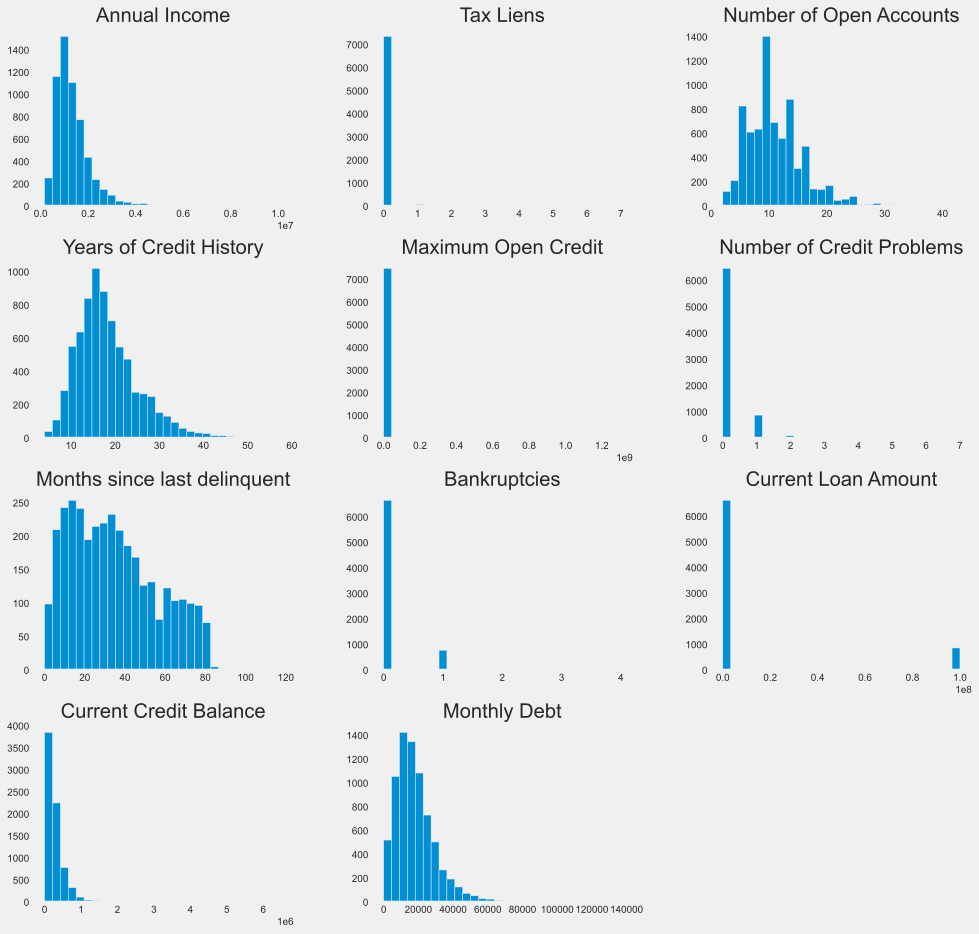

In [257]:
num_features.hist(figsize=(15,15), bins=30, grid=False);

#### 2.2.2 Категориальные признаки<a class='anchor' id='cat_features'>

In [258]:
cat_features = df_train.select_dtypes(include='object').columns.tolist()

for cat_name in cat_features:
    print(str(cat_name) + '\n\n' + str(df_train[cat_name].value_counts()) + '\n' + '_' * 40 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
________________________________________

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
________________________________________

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
__________________________

#### 2.2.3 Матрица корреляций<a class='anchor' id='corr'>

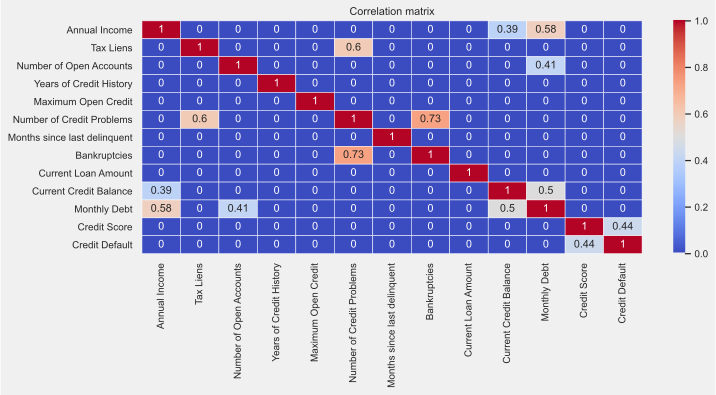

In [259]:
plt.figure(figsize = (10, 4))

sns.set(font_scale=0.9)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### 3. Проверка данных<a class='anchor' id='data_check'>

#### 3.1 Обработка выбросов<a class='anchor' id='outlier'>

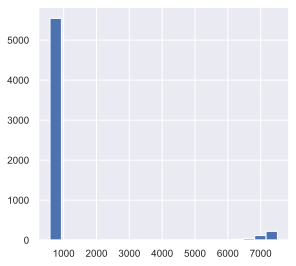

In [260]:
df_train['Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

По данным сайта https://www.investopedia.com/terms/c/credit_score.asp можно увидеть, что максимальное значение **'Credit score'** примерно равно 850. В нашем случае есть 400 значений, превосходящих максимальную величину.

In [261]:
df_train[df_train['Credit Score'] > 850]['Credit Score'].count()

400

Разделим эти значения на 10

In [262]:
df_train['Credit_Score_Outlier'] = 0
df_train.loc[df_train['Credit Score'] > 1000, 'Credit_Score_Outlier'] = 1
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 850, 'Credit Score'] / 10

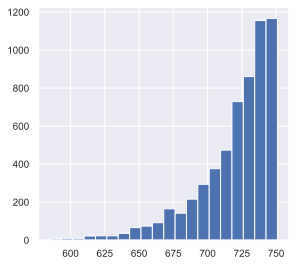

In [263]:
df_train['Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

In [264]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

870 значений с аномально большим значением. Заменим эти значения медианой

In [265]:
df_train['Current Loan Amount Outlier'] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

<AxesSubplot:>

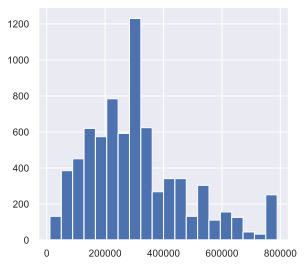

In [266]:
df_train['Current Loan Amount'].hist(bins = 20, figsize = (4, 4))

In [267]:
max_credit = df_train['Current Loan Amount'].max()

In [268]:
df_train[df_train['Maximum Open Credit'] > max_credit]['Maximum Open Credit'].value_counts()

1887710.0    2
854502.0     2
946418.0     2
1494592.0    2
1029226.0    2
            ..
1447270.0    1
846516.0     1
1047222.0    1
1209714.0    1
918962.0     1
Name: Maximum Open Credit, Length: 1870, dtype: int64

In [269]:
df_train['Maximum Open Credit Outlier'] = 0
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

#### 3.2 Обработка пропусков<a class='anchor' id='nan'>

In [270]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Credit_Score_Outlier               0
Current Loan Amount Outlier        0
Maximum Open Credit Outlier        0
dtype: int64

**Annual Income** - заполняем медианой

In [271]:
df_train['Annual Income'].median()

1168386.0

In [272]:
df_train['Annual Income NaN'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income NaN'] = 1
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace = True)
df_train['Annual Income'].isna().sum()

0

<AxesSubplot:>

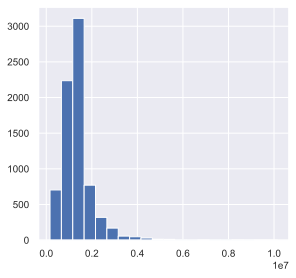

In [273]:
df_train['Annual Income'].hist(bins = 20, figsize = (4, 4))

**Months since last delinquent** удаляем т.к. пропущено больше половины значений

In [274]:
df_train.drop('Months since last delinquent', axis=1, inplace=True)

**Bankruptcies** заменяем медианой

In [275]:
df_train['Bankruptcies NaN'] = 0
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace = True)
df_train['Bankruptcies'].isna().sum()

0

**Credit Score** заменяем медианой

In [276]:
df_train['Credit Score NaN'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score NaN'] = 1
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace = True)
df_train['Credit Score'].isna().sum()

0

<AxesSubplot:>

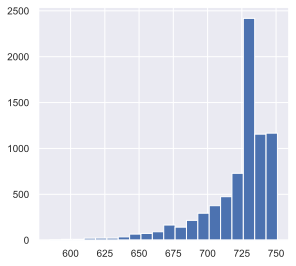

In [277]:
df_train['Credit Score'].hist(bins = 20, figsize = (4, 4))

In [278]:
df_train.isna().sum()

Home Ownership                 0
Annual Income                  0
Years in current job           0
Tax Liens                      0
Number of Open Accounts        0
Years of Credit History        0
Maximum Open Credit            0
Number of Credit Problems      0
Bankruptcies                   0
Purpose                        0
Term                           0
Current Loan Amount            0
Current Credit Balance         0
Monthly Debt                   0
Credit Score                   0
Credit Default                 0
Credit_Score_Outlier           0
Current Loan Amount Outlier    0
Maximum Open Credit Outlier    0
Annual Income NaN              0
Bankruptcies NaN               0
Credit Score NaN               0
dtype: int64

### 4. Создание новых признаков<a class='anchor' id='feature_engineering'>

Заменяем **Term** бинарным признаком (Long Term = 1, Short Term = 0)

In [279]:
df_train['Long Term'] = df_train['Term'].map({'Long Term': 1, 'Short Term': 0})

Заменим строковые значения **Years in current job** категориями (0: <3, 1: 4-6, 2: 7-9, 3: 10+)

In [280]:
df_train['Years in current job'] = df_train['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})

Для **Home Ownership** создаём дамми-переменные

In [281]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'])], axis=1)

Также заменим строковые значения Credit Score категориями в соответсвии с сайтом https://www.investopedia.com/terms/c/credit_score.asp:
* Excellent: 800 to 850
* Very Good: 740 to 799
* Good: 670 to 739
* Fair: 580 to 669
* Poor: 300 to 579

In [282]:
def credit_score_to_cat(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['Credit Score Cat'].fillna(-1, inplace=True)
    return X

In [283]:
df_train = credit_score_to_cat(df_train)

Отбор признаков

In [284]:
feature_names = ['Annual Income', 
                 'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History', 
                 'Maximum Open Credit', 
                 'Number of Credit Problems', 
#                  'Months since last delinquent', 
                 'Bankruptcies',
                 'Current Loan Amount', 
                 'Current Credit Balance', 
                 'Monthly Debt', 
                 'Credit Score', 
                 'Years in current job', 
#                  'Purpose'
                ]

new_feature_names = [
#                          'Home Ownership',
#                          'Term',
#                          'Credit Score Outlier',
#                          'Current Loan Amount Outlier',
#                          'Maximum Open Credit Outlier',
#                          'Annual Income NaN',
#                          'Years in current job NaN',
#                          'Bankruptcies NaN',
#                          'Credit Score NaN',
                         'Long Term',
                         'Have Mortgage',
                         'Home Mortgage',
                         'Own Home',
                         'Rent',
                         'Credit Score Cat'
                    ]

### 5. Создание конвейеров<a class='anchor' id='classes'>

In [285]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999999.0
        
    def fit(self, X):
        """Сохранение статистик""" 
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        """Трансформация данных"""

        # Credit score
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1

        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[df_train['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        # Current Loan Amount
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Maximum Open Credit
        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit
               
        # Annual Income
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)
        
        # Years in current job
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [286]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # Term
        X['Long Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        # Years in current job
        X['Years in current job'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})
        # Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # Credit Score
        X = self.credit_score_to_cat(X)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

### 6. Разбиение на **train** и **test**<a class='anchor' id='split'>

In [287]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [288]:
X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [289]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [290]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

In [291]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 22), (2475, 22), (2500, 22))

In [292]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

In [293]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 28), (2475, 28), (2500, 28))

In [294]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [295]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 18), (2475, 18), (2500, 18))

In [296]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели<a class='anchor' id='model'>

In [297]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

In [298]:
model = catb.CatBoostClassifier(iterations=100, 
                                nan_mode='Min', 
                                silent=True, 
                                random_state=42,
                                class_weights=[1, disbalance],
                                max_depth=5,
                                min_data_in_leaf=5)

In [299]:
model.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid)
         )

In [300]:
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

In [301]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      3631
           1       0.46      0.77      0.57      1394

    accuracy                           0.68      5025
   macro avg       0.67      0.71      0.66      5025
weighted avg       0.76      0.68      0.70      5025

VALID

              precision    recall  f1-score   support

           0       0.82      0.61      0.70      1756
           1       0.41      0.67      0.51       719

    accuracy                           0.63      2475
   macro avg       0.62      0.64      0.61      2475
weighted avg       0.70      0.63      0.65      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1075  681
1                237  482


Метрика F1 для целевого класса 1 выполнена (f1-score > 50)